In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

from mnist import load_mnist

In [2]:
%matplotlib inline

## 4.2　損失関数

Q.なぜ、認識指標での評価ではなく、損失関数を使うのか？<br>
A.損失関数は連続値を扱えるので、勾配降下法を使ってのパラメータ探索に適している。<br>
  一方、認識指標だとデータ数が少ないと指標が離散値となってしまう

In [3]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
        
    batch_size= y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t]) + 1e-7) / batch_size
    # return -np.sum(t * np.log(y + 1e-7))

In [4]:
t = [0, 1]
y = [0.1, 0.9]
cross_entropy_error(np.array(y),np.array(t))

0.10536041565782628

In [5]:
(x_train, t_train), (x_test, t_test) = load_mnist(one_hot_label=True, normalize=False)

In [6]:
x_train.shape

(60000, 784)

In [7]:
x_train.size

47040000

## 4.3 数値微分

In [8]:
def numerical_diff(f, x):
    h = 1e-4
    return (f(x+h) - f(x-h)) / (2*h)

In [9]:
def f_1(x):
    return 0.01*x**2 + 0.1*x

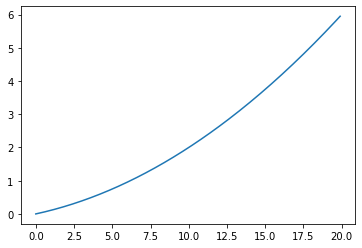

In [10]:
x = np.arange(0, 20 ,0.1)
y = f_1(x)
plt.plot(x,y)

In [11]:
def f_2(x):
    return np.sum(x**2)

In [12]:
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = tmp_val + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 値を元に戻す
        it.iternext()   
        
    return grad

In [13]:
# def numerical_gradient(f, x):
#     """ 勾配"""
#     h = 1e-4
#     grad = np.zeros_like(x)
#     for idx in range(x.size):
#         tmp = x[idx]
#         grad[idx] = (f(tmp+h)- f(tmp-h)) / (2*h)
        
#     return grad

def gradient_descent(f, init_x, lr=0.01, step_num=100):
    """ 勾配降下法"""
    x = init_x
    
    for _ in range(step_num):
        grad = numerical_gradient(f, x)
        x = x - lr*grad
       
    return x

In [14]:

def sigmoid(x):
    return (1 / (1 + np.exp(-x)))

def softmax(a):
    c = np.max(a)
    exp_a = np.exp(a - c)#　オーバーフロー対策
    sum_exp_a = np.sum(exp_a) 
    return exp_a / sum_exp_a

class SimpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3)
        
    def predict(self, x):
        return np.dot(x, self.W)
    
    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)
        return loss

In [15]:
net = SimpleNet()
net.W

array([[-2.05047235, -1.27188508,  0.53786843],
       [ 0.28327175,  0.4446686 , -2.24676348]])

In [16]:
x = np.array([0.6, 0.9])
net.predict(x)

array([-0.97533883, -0.3629293 , -1.69936607])

In [17]:
t = np.array([0,1,0])
net.loss(x, t)

0.5904627443455165

In [18]:
# def f_3(_):
#     return net.loss(x, t)
# dW = numerical_gradient(f_3, net.W)

## 4.5 学習アルゴリズムの実装

In [15]:
class TwoLayerNet:
    """ 二層ニューラルネットワーク"""

    def __init__(self, input_size, hidden_size, output_size, wight_init_std=0.1):
        # 重みの初期化
        self.params = {}
        
        self.params['W1'] = wight_init_std * np.random.randn(input_size, hidden_size)
        self.params['W2'] = wight_init_std * np.random.randn(hidden_size, output_size)
        
        self.params['b1'] = np.zeros(hidden_size)
        self.params['b2'] = np.zeros(output_size)
        

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        return y
    
    def loss(self, x, t):
        y = self.predict(x)
        return cross_entropy_error(y, t)
        
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W : self.loss(x,t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
    
        return grads

In [19]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
print(net.params['W1'].shape)
print(net.params['b1'].shape)
print(net.params['W2'].shape)
print(net.params['b2'].shape)

(784, 100)
(100,)
(100, 10)
(10,)


In [20]:
x = np.random.randn(100, 784)
y = net.predict(x)

In [21]:
# x = np.random.randn(100, 784)
# t = np.random.randn(100, 10)

# grads = net.numerical_gradient(x, t)

In [22]:
# print(grads['W1'].shape)
# print(grads['b1'].shape)
# print(grads['W2'].shape)
# print(['b2'].shape)

In [29]:
(x_train, t_train), (x_test, y_test) = load_mnist(normalize=True, one_hot_label=True)

train_loss_list = []
iters_num=1
train_size=x_train.shape[0]
batch_size=100
learning_rate=0.1

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    # ミニバッチ取得
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 確率的勾配降下法
    grad = network.numerical_gradient(x_batch, t_batch)
    for key in ("W1", "b1", "W2", "b2"):
        network.params[key] = network.params[key] - learning_rate*grad[key]
        
    # 学習経過記録
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)